# Importing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.drop(['delivered_time','pickup_time','cancelled_time'],axis=1,inplace=True)

In [5]:
data.shape

(450000, 17)

# Transforming Features

In [6]:
data.describe()

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassigned_order,session_time
count,450000.000000,450000.000000,450000.000000,450000.000000,433052.000000,432659.000000,450000.000000,432659.000000,449947.000000,13753.0,446325.000000
mean,369143.080767,7763.244016,1.229889,2.968873,104.620909,103.950448,0.011596,0.764165,853.640664,1.0,220.474779
std,131146.906408,5592.880135,0.846183,1.884124,90.135492,89.639646,0.107057,1.066473,1502.976162,0.0,176.713853
min,118350.000000,0.000000,0.000134,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,257342.750000,2805.000000,0.539575,1.470000,36.000000,36.000000,0.000000,0.000000,165.000000,1.0,84.100000
50%,369842.500000,6754.000000,1.138700,2.670000,81.000000,81.000000,0.000000,0.000000,396.000000,1.0,175.550000
75%,482342.250000,11965.000000,1.853000,4.220000,147.000000,146.000000,0.000000,1.000000,948.000000,1.0,316.766667
max,594842.000000,21566.000000,42.038100,22.410000,567.000000,562.000000,1.000000,9.000000,30469.000000,1.0,1298.966667


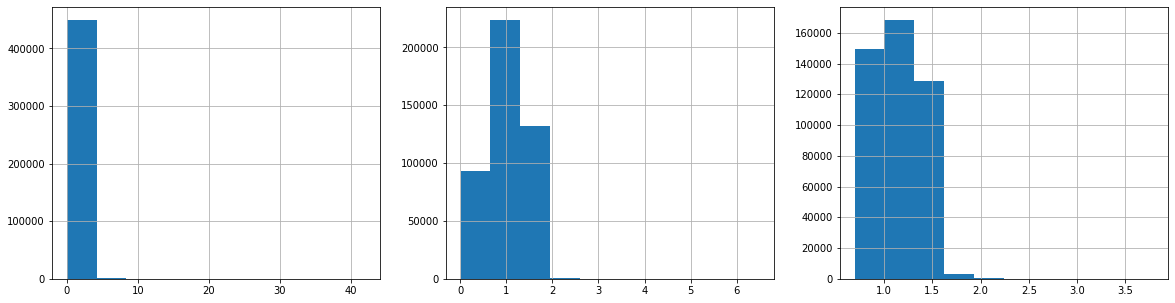

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['first_mile_distance'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['first_mile_distance']).hist()

plt.subplot(1, 3, 3)
np.log(data['first_mile_distance']+2).hist()

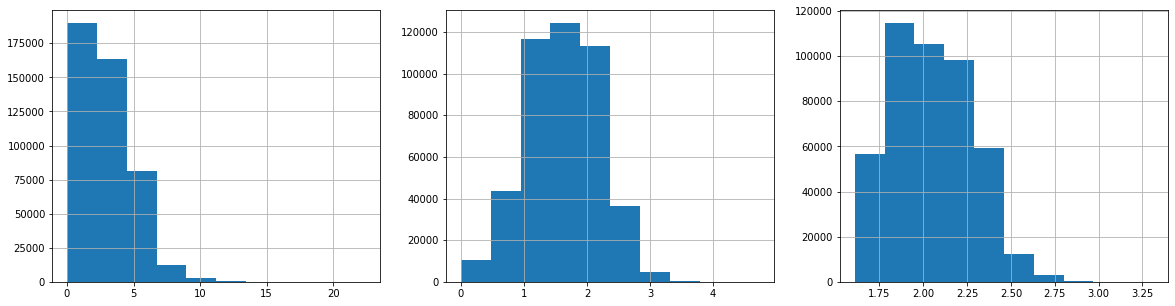

In [8]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['last_mile_distance'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['last_mile_distance']).hist()

plt.subplot(1, 3, 3)
np.log(data['last_mile_distance']+5).hist();

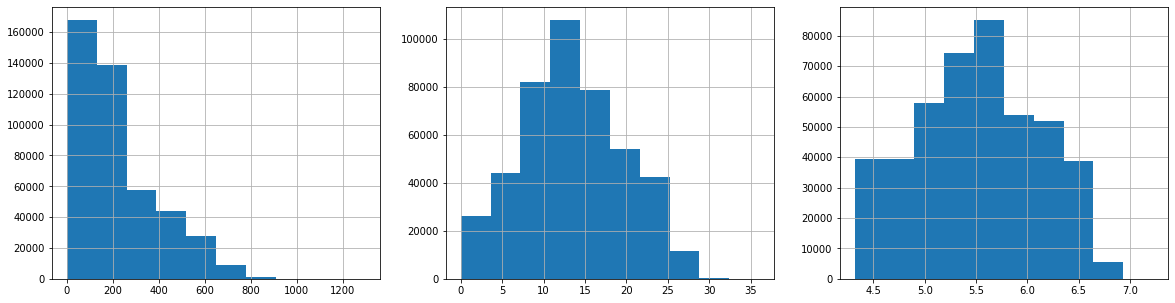

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['session_time'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['session_time']).hist()

plt.subplot(1, 3, 3)
np.log(data['session_time']+75).hist();

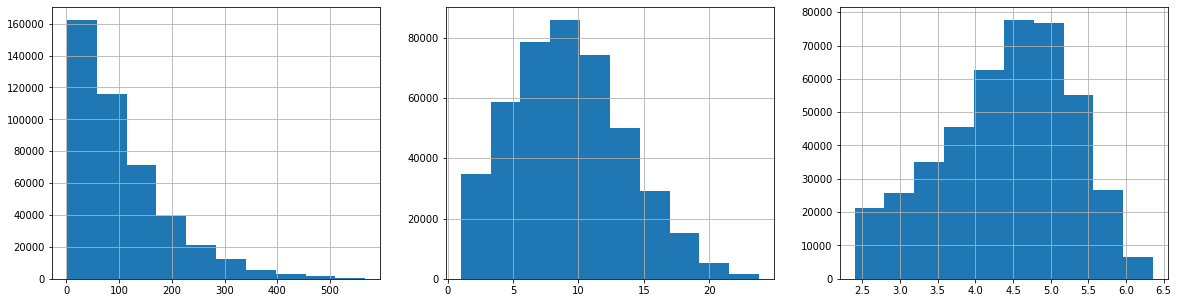

In [10]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['alloted_orders'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['alloted_orders']).hist()

plt.subplot(1, 3, 3)
np.log(data['alloted_orders']+10).hist();

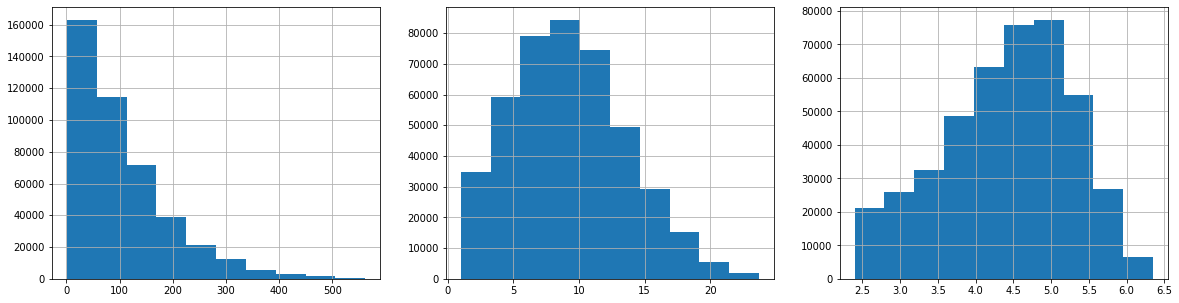

In [11]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['delivered_orders'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['delivered_orders']).hist()

plt.subplot(1, 3, 3)
np.log(data['delivered_orders']+10).hist();

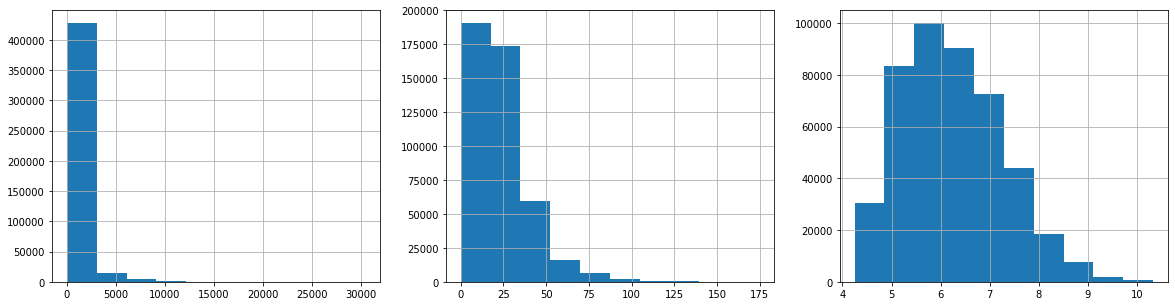

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
data['lifetime_order_count'].hist()

plt.subplot(1, 3, 2)
np.sqrt(data['lifetime_order_count']).hist()

plt.subplot(1, 3, 3)
np.log(data['lifetime_order_count']+70).hist();

In [13]:
# Transforming features for Normal Distribution

data['first_mile_distance'] = np.log(data['first_mile_distance']+2)
data['last_mile_distance'] = np.log(data['last_mile_distance']+5)
data['session_time'] = np.sqrt(data['session_time'])
data['alloted_orders'] = np.sqrt(data['alloted_orders'])
data['delivered_orders'] = np.sqrt(data['delivered_orders'])
data['lifetime_order_count'] = np.log(data['lifetime_order_count']+70)

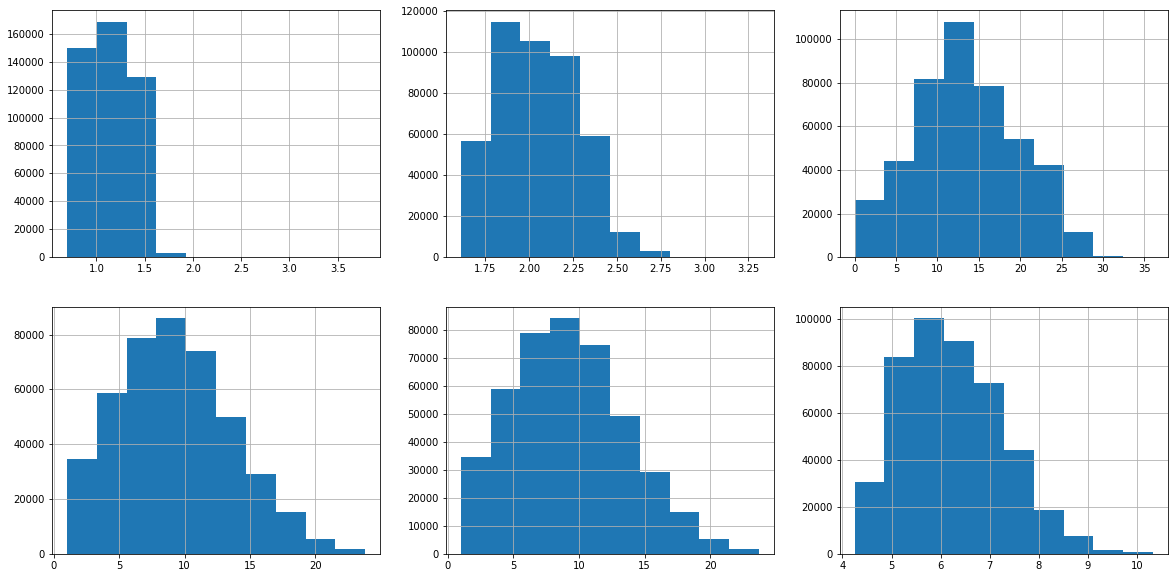

In [14]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
data['first_mile_distance'].hist()

plt.subplot(2, 3, 2)
data['last_mile_distance'].hist()

plt.subplot(2, 3, 3)
data['session_time'].hist();

plt.subplot(2, 3, 4)
data['alloted_orders'].hist()

plt.subplot(2, 3, 5)
data['delivered_orders'].hist()

plt.subplot(2, 3, 6)
data['lifetime_order_count'].hist();

# Date Time Columns

In [15]:
data['accept_time'] = pd.to_datetime(data['accept_time'])
data['order_time'] = pd.to_datetime(data['order_time'])
data['allot_time'] = pd.to_datetime(data['allot_time'])

data['order_time_hour'] = data['order_time'].dt.hour
data['day'] = data['order_time'].dt.dayofweek

data['Time_delay_to_accept_order'] = data['accept_time'] - data['order_time']
seconds = data['Time_delay_to_accept_order'].apply(lambda x : x.total_seconds())
data['Time_delay_to_accept_order_in_minutes'] = (seconds % 3600) // 60

In [16]:
indices = data[data['accept_time'].isnull() == True].index

data['Order_Acceptance'] = np.nan

for i in indices :
  data['Order_Acceptance'][i] = 0

data['Order_Acceptance'] = data['Order_Acceptance'].fillna(1)

# Dealing with Null Values

In [17]:
data['session_time'] = data['session_time'].fillna(data['session_time'].mean())

data['Time_delay_to_accept_order_in_minutes'] = data['Time_delay_to_accept_order_in_minutes'].fillna(999)

data['lifetime_order_count'] = data['lifetime_order_count'].fillna(data['lifetime_order_count'].groupby(by=data['rider_id']).max())
data['lifetime_order_count'] = data['lifetime_order_count'].fillna(0)

data['alloted_orders'] = data['alloted_orders'].fillna(data['alloted_orders'].groupby(by=data['rider_id']).mean())
data['alloted_orders'] = data['alloted_orders'].fillna(0)

data['delivered_orders'] = data['delivered_orders'].fillna(data['delivered_orders'].groupby(by=data['rider_id']).mean())
data['delivered_orders'] = data['delivered_orders'].fillna(0)

data['undelivered_orders'] = data['undelivered_orders'].fillna(data['undelivered_orders'].groupby(by=data['rider_id']).mean())
data['undelivered_orders'] = data['undelivered_orders'].fillna(0)

data['reassignment_method']  = data['reassignment_method'].fillna('No value')
data['reassignment_reason'] = data['reassignment_reason'].fillna('No value') 
data['reassigned_order'] = data['reassigned_order'].fillna(0)

# Feature Engineering

In [ ]:
k = data[['undelivered_orders']].groupby(data['rider_id']).max()
l = k[k['undelivered_orders']>0].index
data['undelivered'] = np.nan

for i in range(450000) :
  if data['rider_id'][i] in l :
    data['undelivered'][i] = 1
  else :
    data['undelivered'][i] = 0


k1 = data[['delivered_orders']].groupby(data['rider_id']).max()
l1 = k1[k1['delivered_orders']>0].index
data['delivered'] = np.nan

for i in range(450000) :
  if data['rider_id'][i] in l1 :
    data['delivered'][i] = 0
  else :
    data['delivered'][i] = 1

In [ ]:
data['orders_ratio'] = np.sqrt(data['undelivered_orders']/data['delivered_orders'])
data['orders_efficiency'] = np.sqrt(data['delivered_orders']/data['alloted_orders'])

data['orders_ratio'] = data['orders_ratio'].fillna(0)
data['orders_efficiency'] = data['orders_efficiency'].fillna(0)

In [ ]:
data['Day_Type'] = np.nan

for i in range(450000) :
  if data['order_time_hour'][i] in {4,5,6,7} :
    data['Day_Type'][i] = 'Early_Morning'

  elif data['order_time_hour'][i] in {8,9,10,11} :
    data['Day_Type'][i] = 'Morning'

  elif data['order_time_hour'][i] in {12,13,14,15} :
    data['Day_Type'][i] = 'Afternoon'

  elif data['order_time_hour'][i] in {16,17,18,19} :
    data['Day_Type'][i] = 'Evening'

  elif data['order_time_hour'][i] in {20,21,22,23} :
    data['Day_Type'][i] = 'Night'

  else :
     data['Day_Type'][i] = 'Mid-Night'

In [ ]:
data['mile_ratio'] = data['first_mile_distance']/data['last_mile_distance']
data['mile_distance'] = np.abs(data['last_mile_distance'] - data['first_mile_distance'])
data['distance'] = (data['first_mile_distance'] + data['last_mile_distance'])**2

In [ ]:
data['orders_fewer'] = (data['lifetime_order_count'] - data['alloted_orders'])**2
data['orders'] = (data['alloted_orders'] + data['delivered_orders'] + data['undelivered_orders'])**2
data['orders_multiply'] = data['alloted_orders']*data['delivered_orders']

#X and y

In [ ]:
corr= data.corr()
matrix = np.triu(corr)
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, mask=matrix, cmap="YlGnBu");

In [ ]:
X = data[['rider_id', 'first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count',
        'reassignment_method', 'reassignment_reason','reassigned_order', 'session_time', 'order_time_hour','Time_delay_to_accept_order_in_minutes','day','mile_distance', 
       'Order_Acceptance',  'undelivered', 'delivered', 'mile_ratio',  'orders_ratio', 'orders_efficiency', 'Day_Type','orders_fewer', 'orders','distance', 'orders_multiply']]

y = data['cancelled']

In [ ]:
X.shape

In [ ]:
X_copy = pd.get_dummies(X)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_copy,y,test_size=0.2,random_state=0)

# XGB Classifier

In [ ]:
# model = XGBClassifier(n_estimators=350,scale_pos_weight=0.9)
# model.fit(X_train,y_train)
# y_pred = model.predict_proba(X_train)
# y_pred1 = model.predict_proba(X_test)
# print(roc_auc_score(y_train,y_pred[:,1]) , roc_auc_score(y_test,y_pred1[:,1]))

In [ ]:
# 0.8910214894800674 0.856234058958678

In [ ]:
model = XGBClassifier(n_estimators=350,scale_pos_weight=0.9)
model.fit(X_copy,y)

# test

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
# Feature Transformation

test['first_mile_distance'] = np.log(test['first_mile_distance']+2)
test['last_mile_distance'] = np.log(test['last_mile_distance']+5)
test['session_time'] = np.sqrt(test['session_time'])
test['alloted_orders'] = np.sqrt(test['alloted_orders'])
test['delivered_orders'] = np.sqrt(test['delivered_orders'])
test['lifetime_order_count'] = np.log(test['lifetime_order_count']+70)

In [ ]:
# Date Time Columns

test['accept_time'] = pd.to_datetime(test['accept_time'])
test['order_time'] = pd.to_datetime(test['order_time'])
test['allot_time'] = pd.to_datetime(test['allot_time'])

test['order_time_hour'] = test['order_time'].dt.hour
test['day'] = test['order_time'].dt.dayofweek

test['Time_delay_to_accept_order'] = test['accept_time'] - test['order_time']
second = test['Time_delay_to_accept_order'].apply(lambda x : x.total_seconds())
test['Time_delay_to_accept_order_in_minutes'] = (second % 3600) // 60


indices_test = test[test['accept_time'].isnull() == True].index

test['Order_Acceptance'] = np.nan

for i in indices_test :
  test['Order_Acceptance'][i] = 0

test['Order_Acceptance'] = test['Order_Acceptance'].fillna(1)

In [ ]:
# Null Values

test['session_time'] = test['session_time'].fillna(test['session_time'].mean())

test['Time_delay_to_accept_order_in_minutes'] = test['Time_delay_to_accept_order_in_minutes'].fillna(999)

test['lifetime_order_count'] = test['lifetime_order_count'].fillna(test['lifetime_order_count'].groupby(by=test['rider_id']).max())
test['lifetime_order_count'] = test['lifetime_order_count'].fillna(0)

test['alloted_orders'] = test['alloted_orders'].fillna(test['alloted_orders'].groupby(by=test['rider_id']).mean())
test['alloted_orders'] = test['alloted_orders'].fillna(0)

test['delivered_orders'] = test['delivered_orders'].fillna(test['delivered_orders'].groupby(by=test['rider_id']).mean())
test['delivered_orders'] = test['delivered_orders'].fillna(0)

test['undelivered_orders'] = test['undelivered_orders'].fillna(test['undelivered_orders'].groupby(by=test['rider_id']).mean())
test['undelivered_orders'] = test['undelivered_orders'].fillna(0)

test['reassignment_method']  = test['reassignment_method'].fillna('No value')
test['reassignment_reason'] = test['reassignment_reason'].fillna('No value') 
test['reassigned_order'] = test['reassigned_order'].fillna(0)

In [ ]:
# Feature Engineering

k2 = test[['undelivered_orders']].groupby(test['rider_id']).max()
l2 = k2[k2['undelivered_orders']>0].index
test['undelivered'] = np.nan

for i in range(144844) :
  if test['rider_id'][i] in l2 :
    test['undelivered'][i] = 1
  else :
    test['undelivered'][i] = 0


k3 = test[['delivered_orders']].groupby(test['rider_id']).max()
l3 = k3[k3['delivered_orders']>0].index
test['delivered'] = np.nan

for i in range(144844) :
  if test['rider_id'][i] in l3 :
    test['delivered'][i] = 0
  else :
    test['delivered'][i] = 1


test['orders_ratio'] = np.sqrt(test['undelivered_orders']/test['delivered_orders'])
test['orders_efficiency'] = np.sqrt(test['delivered_orders']/test['alloted_orders'])
test['orders_ratio'] = test['orders_ratio'].fillna(0)
test['orders_efficiency'] = test['orders_efficiency'].fillna(0)


test['Day_Type'] = np.nan

for i in range(144844) :
  if test['order_time_hour'][i] in {4,5,6,7} :
    test['Day_Type'][i] = 'Early_Morning'

  elif test['order_time_hour'][i] in {8,9,10,11} :
    test['Day_Type'][i] = 'Morning'

  elif test['order_time_hour'][i] in {12,13,14,15} :
    test['Day_Type'][i] = 'Afternoon'

  elif test['order_time_hour'][i] in {16,17,18,19} :
    test['Day_Type'][i] = 'Evening'

  elif test['order_time_hour'][i] in {20,21,22,23} :
    test['Day_Type'][i] = 'Night'

  else :
     test['Day_Type'][i] = 'Mid-Night'


test['mile_ratio'] = test['first_mile_distance']/test['last_mile_distance']
test['mile_distance'] = np.abs(test['last_mile_distance'] - test['first_mile_distance'])
test['distance'] = (test['first_mile_distance'] + test['last_mile_distance'])**2

test['orders_fewer'] = (test['lifetime_order_count'] - test['alloted_orders'])**2
test['orders'] = (test['alloted_orders'] + test['delivered_orders'] + test['undelivered_orders'])**2
test['orders_multiply'] = test['alloted_orders']*test['delivered_orders']

In [ ]:
df = test[['rider_id', 'first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count',
        'reassignment_method', 'reassignment_reason','reassigned_order', 'session_time', 'order_time_hour','Time_delay_to_accept_order_in_minutes','day','mile_distance', 
       'Order_Acceptance',  'undelivered', 'delivered', 'mile_ratio',  'orders_ratio', 'orders_efficiency', 'Day_Type','orders_fewer', 'orders','distance', 'orders_multiply']]

test_copy = pd.get_dummies(df)

In [ ]:
preds = model.predict_proba(test_copy)

In [ ]:
submission = pd.DataFrame(columns=['order_id','cancelled']) 
submission['order_id'] = test['order_id']
submission['cancelled'] = preds[:,1]

In [ ]:
submission.head()

In [ ]:
submission.shape

In [ ]:
submission.to_csv("submission.csv",index = False)